# Weak/Integral SINDy Feature Overview

This notebook provides a simple overview of the weak form PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614) and Reinbold, P. A., Gurevich, D. R., & Grigoriev, R. O. (2020). Using noisy or incomplete data to discover models of spatiotemporal dynamics. Physical Review E, 101(1), 010203. Jupyter notebook written by Alan Kaptanoglu.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz, rossler

import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

In [2]:
# Import some interpolation and integration functions
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import trapezoid
from pysindy.differentiation import FiniteDifference
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d


# Convert u_dot into a weak form using the pre-defined ode_lib
def convert_u_dot_0D(u, t, ode_lib):  # For weak form ODES
    K = ode_lib.K
    num_pts_per_domain = ode_lib.num_pts_per_domain
    u_dot_integral = np.zeros((K, u.shape[-1]))
    for j in range(u.shape[-1]):
        u_interp = interp1d(t, u[:, j], kind='cubic')
        for k in range(K):
            # Interpolate u onto the kth subdomain
            u_new = u_interp(ode_lib.tgrid_k[k, :])
            # Get the smooth weights on the kth subdomain
            w_diff = ode_lib._smooth_ppoly(
                        [],
                        ode_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    u_new * w_diff, 
                    x=ode_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral


# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_1D(u, t, pde_lib):  # For weak form 1D PDES
    K = pde_lib.K
    num_pts_per_domain = pde_lib.num_pts_per_domain
    x = pde_lib.spatial_grid
    u_dot_integral = np.zeros((K, u.shape[-1]))
    # Define interpolation object to interpolate u(x, time) onto the grid
    # spanned by X, t
    for j in range(u.shape[-1]):
        u_interp = RectBivariateSpline(x, t, u[:, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :, :])
            tgrid = np.ravel(pde_lib.t[k, :, :])
            # Interpolate u onto the kth subdomain
            u_new = u_interp.ev(X, tgrid)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                        np.reshape(pde_lib.xgrid_k[k, :], (num_pts_per_domain, 1)),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over x, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        u_new * w_diff, 
                        x=pde_lib.xgrid_k[k, :], 
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral


# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_2D(u, t, pde_lib):  # For weak form 2D PDES
    K = pde_lib.K  
    num_pts_per_domain = pde_lib.num_pts_per_domain
    x = pde_lib.spatial_grid
    u_dot_integral = np.zeros((K, 2))
    for j in range(u.shape[-1]):
        # Define interpolation object to interpolate u(x, y, t) onto the grid
        # spanned by X, Y, t
        u_interp = RegularGridInterpolator((pde_lib.spatial_grid[:, 0, 0], 
                                            pde_lib.spatial_grid[0, :, 1],
                                            t), 
                                           u[:, :, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :, :, :])
            Y = np.ravel(pde_lib.Y[k, :, :, :])
            tgrid = np.ravel(pde_lib.t[k, :, :, :])
            XYt = np.array((X, Y, tgrid)).T
            # Interpolate u onto the kth subdomain
            u_new = u_interp(XYt)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                        np.transpose((pde_lib.xgrid_k[k, :], pde_lib.ygrid_k[k, :])),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over x, y, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        trapezoid(
                            u_new * w_diff, 
                            x=pde_lib.xgrid_k[k, :], 
                            axis=0
                        ),
                        x=pde_lib.ygrid_k[k, :],
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral


# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_3D(u, t, pde_lib):  # For weak form 3D PDES
    K = pde_lib.K  
    num_pts_per_domain = pde_lib.num_pts_per_domain
    u_dot_integral = np.zeros((K, 2))
    for j in range(u.shape[-1]):
        # Define interpolation object to interpolate u(x, y, t) onto the grid
        # spanned by X, Y, t
        u_interp = RegularGridInterpolator((pde_lib.spatial_grid[:, 0, 0, 0],
                                            pde_lib.spatial_grid[0, :, 0, 1],
                                            pde_lib.spatial_grid[0, 0, :, 2],
                                            t), 
                                           u[:, :, :, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :, :, :, :])
            Y = np.ravel(pde_lib.Y[k, :, :, :, :])
            Z = np.ravel(pde_lib.Z[k, :, :, :, :])
            tgrid = np.ravel(pde_lib.t[k, :, :, :, :])
            XYZt = np.array((X, Y, Z, tgrid)).T
            # Interpolate u onto the kth subdomain
            u_new = u_interp(XYZt)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                        np.transpose((pde_lib.xgrid_k[k, :], 
                                      pde_lib.ygrid_k[k, :],
                                      pde_lib.zgrid_k[k, :])),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over x, y, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        trapezoid(
                            trapezoid(
                                u_new * w_diff, 
                                x=pde_lib.xgrid_k[k, :], 
                                axis=0
                            ),
                            x=pde_lib.ygrid_k[k, :],
                            axis=0
                        ),
                        x=pde_lib.zgrid_k[k, :],
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral

# Test weak form ODE functionality on Lorenz equation

In [3]:
# Generate measurement data
dt = .002
t_train = np.arange(0, 10, dt)
u0_train = [-8, 8, 27]
u_train = odeint(lorenz, u0_train, t_train)

# Instantiate and fit the SINDy model with u_dot
u_dot = ps.FiniteDifference()._differentiate(u_train, t=dt)
model = ps.SINDy()
model.fit(u_train, x_dot=u_dot, t=dt)
model.print()

# Define weak form ODE library via weak_form=True, 
# defaults to derivative_order = 0 if not specified,
# and if spatial_grid is not specified, defaults to None,
# which allows weak form ODEs.
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
ode_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        temporal_grid=t_train, include_bias=True,
                        is_uniform=True, weak_form=True, 
                        num_pts_per_domain=100, K=100)

u_dot_train_integral = convert_u_dot_0D(u_train, t_train, ode_lib)

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.SR3(threshold=0.05, thresholder='l1', 
                   max_iter=1000, normalize_columns=True,
                   tol=1e-10)
model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train_integral)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.001 x0 + -1.000 x1 + -1.000 x0x2
(x2)' = 0.001 1 + -2.667 x2 + 1.000 x0x1


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:335: ConvergenceWarning: SR3._reduce did not converge after 1000 iterations.
  ConvergenceWarning,


### Performance should improve as number of sub-domain integrations points (num_pts_per_domain) and number of sub-domains (K) increase. Let's use some noisy Lorenz data and investigate.

In [4]:
# Generate measurement data
dt = .002
t_train = np.arange(0, 10, dt)
u0_train = [-8, 8, 27]
u0_test = [8, 7, 15]
u_train = odeint(lorenz, u0_train, t_train)
u_test = odeint(lorenz, u0_test, t_train)
rmse = mean_squared_error(u_train, np.zeros((u_train).shape), squared=False)
u_dot_clean = ps.FiniteDifference()._differentiate(u_test, t=dt)
u_clean = u_test
u_train = u_train + np.random.normal(0, rmse / 5.0, u_train.shape)   # Add 20% noise
rmse = mean_squared_error(u_test, np.zeros(u_test.shape), squared=False)
u_test = u_test + np.random.normal(0, rmse / 5.0, u_test.shape)   # Add 20% noise
u_dot = ps.FiniteDifference()._differentiate(u_test, t=dt)

# Same library terms as before
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]

# Scan over the number of integration points and the number of subdomains
n = 10
errs = np.zeros((n, n))
pts_scan = np.linspace(4, 40, n, dtype=int)
K_scan = np.linspace(20, 300, n, dtype=int)
for i, K in enumerate(K_scan):
    print(i)  # Track loop progress
    for j, pts in enumerate(pts_scan):
        ode_lib = ps.PDELibrary(library_functions=library_functions, 
                                function_names=library_function_names, 
                                temporal_grid=t_train, include_bias=True,
                                is_uniform=True, weak_form=True, 
                                num_pts_per_domain=pts, K=K)
        opt = ps.SR3(threshold=0.05, thresholder='l0', 
                           max_iter=1000, normalize_columns=True,
                           tol=1e-10)
        u_dot_train_integral = convert_u_dot_0D(u_train, t_train, ode_lib)

        # Instantiate and fit the SINDy model with the integral of u_dot
        model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
        model.fit(u_train, x_dot=u_dot_train_integral, quiet=True)
        # model.print()
        errs[i, j] = np.sqrt((np.sum((u_dot_train_integral - opt.Theta_ @ opt.coef_.T) ** 2
                                    ) / np.sum(u_dot_train_integral ** 2)
                       ) / u_dot_train_integral.shape[0])
        # print(i, j, pts, K, errs[i, j])

0
1
2
3
4
5
6
7
8
9


### Performance clearly improves as the number of subdomains and number of integrations points increase! We can also see that Lorenz is correctly identified despite ~20% noise levels

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


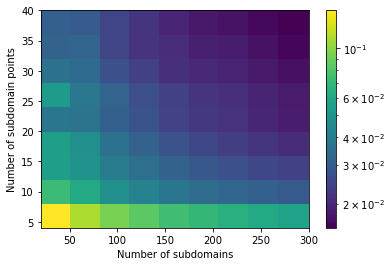

In [5]:
from matplotlib.colors import LogNorm
plt.pcolor(K_scan, pts_scan, errs.T, norm=LogNorm())
plt.xlabel('Number of subdomains')
plt.ylabel('Number of subdomain points')
plt.colorbar()

### The default scikit-learn functionality for model.predict is to return x_dot of the same type as the training data. So for weak form, model.predict returns a prediction of the weak form of x_dot, rather than a prediction of x_dot. 
### We can get around this with a bit of a cheat... inputting the model coefficients from the weak form into the original (not weak) model, and use this to predict!
### Beware, this requires: 
1. That the libraries and library ordering are identical in the two models!
2. For PDEs, the spatial grids must be identical. Fortunately the default is to set the random seed generator to 100.
3. Note that the candidate libraries $\Theta$ are fundamentally different in the weak and non-weak models. In the former, all the columns are integrated in time (and for PDEs, also in space)! This means if you forecast the weak model coefficients with the non-weak model, you are using a $\Theta$ matrix that is very noisy! In other words, using the weak form fixed the issues with noise, but forecasting with the original model still has the noise in $\Theta$.
4. For all these reasons, we will use the error in the coefficients, rather than the error in the predictions, after this example.

Weak form model: 
(x0)' = -3.906 1 + -5.445 x0 + 8.997 x1 + 0.447 x2 + 0.123 x0x0 + 0.002 x1x1 + -0.015 x2x2 + -0.092 x0x1 + -0.118 x0x2 + -0.011 x1x2
(x1)' = 0.226 1 + 22.767 x0 + 0.075 x1 + -0.083 x2 + -0.119 x0x0 + 0.035 x1x1 + 0.009 x2x2 + 0.032 x0x1 + -0.865 x0x2 + 0.016 x1x2
(x2)' = -9.379 1 + -1.141 x0 + -0.446 x1 + -1.981 x2 + -0.097 x0x0 + 0.107 x1x1 + -0.006 x2x2 + 0.904 x0x1 + 0.030 x0x2 + 0.030 x1x2
Regular model: 
(x0)' = -1.098 1 + 4.811 x0 + 1.195 x1 + 0.862 x2 + 0.027 x0^2 + 0.208 x0 x1 + -0.336 x0 x2 + -0.171 x1^2 + 0.160 x1 x2 + -0.034 x2^2
(x1)' = 9.174 1 + 7.419 x0 + 8.759 x1 + -0.388 x2 + -0.173 x0^2 + 0.519 x0 x1 + -0.403 x0 x2 + -0.283 x1^2 + -0.272 x1 x2 + 0.015 x2^2
(x2)' = -20.748 1 + -1.726 x0 + 1.449 x1 + -1.025 x2 + 0.437 x0^2 + -0.056 x0 x1 + 0.075 x0 x2 + 0.416 x1^2 + -0.073 x1 x2 + -0.029 x2^2
['1', 'x0', 'x1', 'x2', 'x0x0', 'x1x1', 'x2x2', 'x0x1', 'x0x2', 'x1x2']
['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']


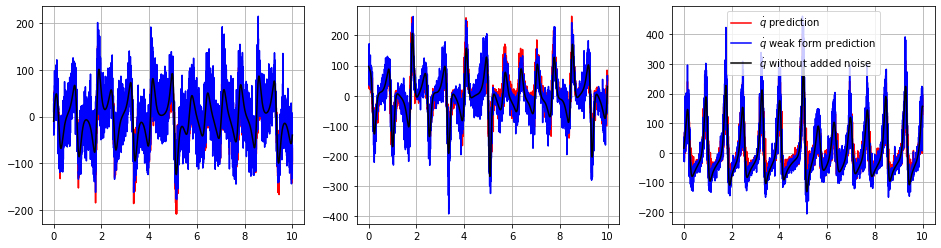

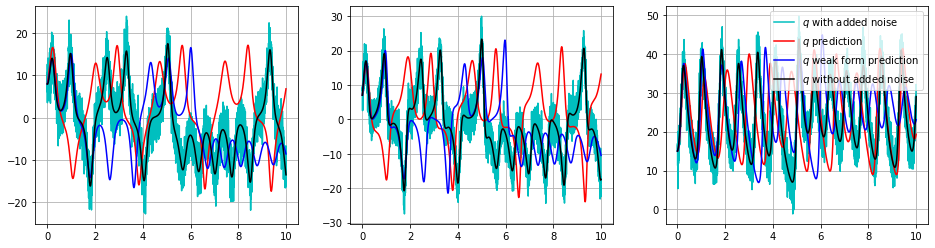

In [6]:
# Fit a weak form model
ode_lib = ps.PDELibrary(library_functions=library_functions, 
                                function_names=library_function_names, 
                                temporal_grid=t_train, include_bias=True,
                                is_uniform=True, weak_form=True, 
                                num_pts_per_domain=100, K=5000)
opt = ps.SR3(threshold=0.5, thresholder='l0', 
             max_iter=10000, normalize_columns=True,
             tol=1e-10)
u_dot_train_integral = convert_u_dot_0D(u_train, t_train, ode_lib)
model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
model.fit(u_train, x_dot=u_dot_train_integral, quiet=True)
print('Weak form model: ')
model.print()

# Instantiate and fit a non-weak SINDy model
optimizer = ps.SR3(threshold=0.5, thresholder='l0', 
                   max_iter=10000, normalize_columns=True,
                   tol=1e-10)
original_model = ps.SINDy(optimizer=optimizer)
original_model.fit(u_train, t=dt)
print('Regular model: ')
original_model.print()
err_not_weak = np.sqrt((np.sum((u_dot - optimizer.Theta_ @ optimizer.coef_.T) ** 2
                              ) / np.sum(u_dot ** 2)
                       ) / u_dot.shape[0])

u_pred = original_model.simulate(u0_test, t=t_train)
u_dot_pred = original_model.predict(u_test)

# Need to swap coefficient order because model and original_model
# are using differently ordered libraries!
print(model.get_feature_names())
print(original_model.get_feature_names())
coef_inds = np.asarray([0, 1, 2, 3, 4, 7, 8, 5, 9, 6], dtype=int)

optimizer.coef_ = opt.coef_[:, coef_inds]
u_dot_weak = original_model.predict(u_test)
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    #plt.plot(t_train, u_dot[:, i], label='u_dot with added noise')
    plt.plot(t_train, u_dot_pred[:, i], 'r', label=r'$\dot{q}$ prediction')
    plt.plot(t_train, u_dot_weak[:, i], 'b', label=r'$\dot{q}$ weak form prediction')
    plt.plot(t_train, u_dot_clean[:, i], 'k', label=r'$\dot{q}$ without added noise')
    plt.grid(True)
    if i == 2:
        plt.legend()
    
u_weak = original_model.simulate(u0_test, t=t_train)
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_test[:, i], 'c', label=r'$q$ with added noise')
    plt.plot(t_train, u_pred[:, i], 'r', label=r'$q$ prediction')
    plt.plot(t_train, u_weak[:, i], 'b', label=r'$q$ weak form prediction')
    plt.plot(t_train, u_clean[:, i], 'k', label=r'$q$ without added noise')
    plt.grid(True)
    if i == 2:
        plt.legend()

# Test weak form PDE functionality on Burgers' equation with 20% noise
Burgers' equation is
$u_t = -uu_x + 0.1 u_{xx}$. We will repeat all the same steps

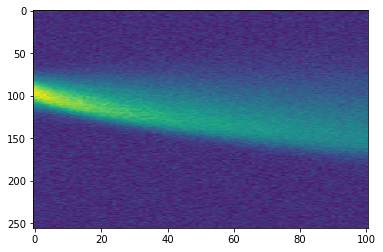

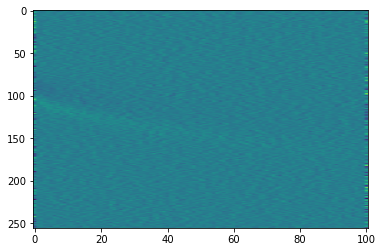

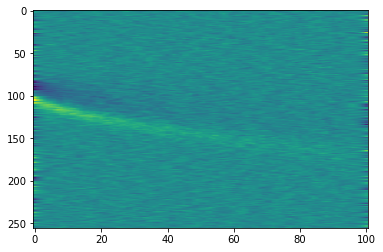

In [7]:
# Load data from .mat file
data = loadmat('data/burgers.mat')
time = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 5.0, u.shape)  # add 20% noise

# Plot u and u_dot
plt.figure()
plt.imshow(u, aspect='auto')
u_shaped = np.reshape(u, (len(x), len(time), 1))
u_dot = np.zeros((len(x), len(time), 1))

# See how much SmoothedFiniteDifference improves the derivatives!
plt.figure()
for i in range(len(x)):
    u_dot[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(u_dot[:, :, 0], aspect='auto')
plt.figure()
for i in range(len(x)):
    u_dot[i, :, :] = ps.SmoothedFiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(u_dot[:, :, 0], aspect='auto')

In [8]:
# Split into training and testing data
train = range(0, int(len(time) * 0.6), 1)
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
u_dot_train = u_dot[:, train]
u_dot_test = u_dot[:, test]
t_train = time[train]
t_test = time[test]

# Flatten into 2D shape for SINDy model optimization
u_flattened = np.reshape(u, (len(x) * len(time), 1))
u_dot_flattened = np.reshape(u_dot, (len(x) * len(time), 1))
u_dot_train_flattened = np.reshape(u_dot_train, (len(x) * len(t_train), 1))
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_dot_test_flattened = np.reshape(u_dot_test, (len(x) * len(t_test), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))

# Define weak form PDE library via weak_form=True
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Show that the default behavior is that identical PDELibrary calls
# will generate identical subdomain grids, by setting the random
# seed generator to 100. 
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x,
                        temporal_grid=t_train, include_bias=False,
                        is_uniform=True, weak_form=True, K=500,
                        num_pts_per_domain=50)
domain_centers1 = pde_lib.domain_centers
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x,
                        temporal_grid=t_train, include_bias=False,
                        is_uniform=True, weak_form=True, K=500,
                        num_pts_per_domain=50)
domain_centers2 = pde_lib.domain_centers
print(np.all(domain_centers1 == domain_centers2))

# Set a different random seed
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x,
                        temporal_grid=t_train, include_bias=False,
                        is_uniform=True, weak_form=True, K=500,
                        num_pts_per_domain=50, rand_seed=10)
domain_centers3 = pde_lib.domain_centers
print(np.all(domain_centers2 == domain_centers3))

# reshape the data
u = np.reshape(u, (len(x), len(time), 1))
u_train = np.reshape(u_train, (len(x), len(t_train), 1))
u_test = np.reshape(u_test, (len(x), len(t_test), 1))

# Compute the integral u_dot terms
u_dot_integral = convert_u_dot_1D(u, time, pde_lib)
u_dot_train_integral = convert_u_dot_1D(u_train, t_train, pde_lib)
u_dot_test_integral = convert_u_dot_1D(u_test, t_test, pde_lib)

True
False


In [9]:
# Fit a weak form model
optimizer = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_integral)
model.print()

(x0)' = 0.173 x0x0 + 0.092 x0_11 + -1.039 x0x0_1 + 0.114 x0x0x0_11


In [10]:
# Show that a non-weak form model screws this up badly
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x,
                        include_bias=False,
                        is_uniform=True, weak_form=False)

# Fit and predict with the non-weak model
opt = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-10, normalize_columns=True, max_iter=1000)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(u_train_flattened, x_dot=u_dot_train_flattened)

# Prints a very wrong model
model_for_prediction.print()

(x0)' = 0.134 x0 + -0.350 x0x0 + -0.001 x0_1 + -0.370 x0x0_1 + 0.051 x0x0x0_1 + -0.002 x0x0_11 + 0.001 x0x0x0_11


# Test PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$. We will skip noisy data for now, since we have already illustrated the pitfalls and performance with the weak form. We will revisit noisy data for the 2D reaction-diffusion example.

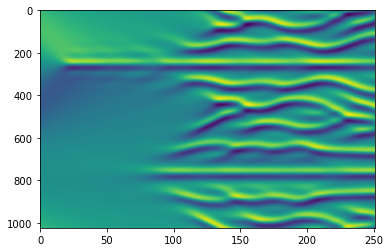

In [11]:
# Load and plot the data
data = loadmat('data/kuramoto_sivishinky.mat')
time = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
u_flattened = np.reshape(u, (len(x) * len(time), 1))
dt = time[1] - time[0]
dx = x[1] - x[0]
plt.figure()
plt.imshow(u, aspect='auto')

# Convert u_dot to weak form and then solve problem with all the optimizers

In [12]:
# Split into training and testing data
train = range(0, len(time) // 2, 1)
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
t_train = time[train]
t_test = time[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))

# Define weak form PDE library via weak_form=True
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=4, spatial_grid=x, Hx=24.5, Ht=20,
                        temporal_grid=time, include_bias=True,
                        is_uniform=True, weak_form=True, num_pts_per_domain=50)

u = np.reshape(u, (len(x), len(time), 1))
u_train = np.reshape(u_train, (len(x), len(t_train), 1))
u_test = np.reshape(u_test, (len(x), len(t_test), 1))
u_dot_train_integral = convert_u_dot_1D(u_train, t_train, pde_lib)
u_dot_test_integral = convert_u_dot_1D(u_test, t_test, pde_lib)
u_dot_integral = convert_u_dot_1D(u, time, pde_lib)

In [13]:
# Run optimizers -- skipping SSR for now
optimizer = ps.STLSQ(threshold=0.001, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

optimizer = ps.SR3(threshold=0.1, max_iter=10000, tol=1e-15, 
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

optimizer = ps.SR3(threshold=0.01, max_iter=10000, tol=1e-15, 
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

# optimizer = ps.SSR(normalize_columns=True, kappa=1e-8)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_flattened, x_dot=ut_integral)
# model.print()

# optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=1e-20)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_flattened, x_dot=ut_integral)
# model.print()

optimizer = ps.FROLS(normalize_columns=True, kappa=1e-7)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

(x0)' = -1.001 x0_11 + -0.011 x0_111 + -1.012 x0_1111 + -1.002 x0x0_1 + 0.002 x0x0x0_11 + 0.002 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:335: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  ConvergenceWarning,


(x0)' = -1.002 x0_11 + -1.021 x0_1111 + -1.003 x0x0_1 + 0.002 x0x0x0_11 + 0.002 x0x0x0_1111
(x0)' = -1.000 x0_11 + -1.027 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
(x0)' = -1.004 x0_11 + -1.051 x0_1111 + -1.004 x0x0_1


In [14]:
# Get average SR3 performance as function of the noise level.
# Used to cross-validate over 10 runs but this takes a long time
cross_val_runs = 1
u = np.squeeze(u)
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
noise_levels = np.linspace(0, rmse / 2.0, 5)
delta_c1 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c2 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c3 = np.zeros((cross_val_runs, len(noise_levels)))
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=4, spatial_grid=x,
                        temporal_grid=time, include_bias=False, K=400,
                        is_uniform=True, weak_form=True, num_pts_per_domain=100)
optimizer = ps.SR3(threshold=0.5, max_iter=500, tol=1e-10, 
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
for i in range(cross_val_runs):
    for j, noise in enumerate(noise_levels):
        print(i, j)
        u_noisy = u + np.random.normal(0, noise, u.shape)
        u_noisy_flattened = np.reshape(u_noisy, (len(x) * len(time), 1))
        u_noisy = np.reshape(u_noisy, (len(x), len(time), 1))
        u_dot_integral = convert_u_dot_1D(u_noisy, time, pde_lib)
        model.fit(u_noisy_flattened, x_dot=u_dot_integral)
        model.print()
        c1 = abs(optimizer.coef_[0, 6])
        c2 = abs(optimizer.coef_[0, 3])
        c3 = abs(optimizer.coef_[0, 5])
        delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
        delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
        delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)

0 0
(x0)' = -0.993 x0_11 + -0.994 x0_1111 + -1.001 x0x0_1
0 1


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:335: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


(x0)' = 0.003 x0 + -0.997 x0_11 + -0.996 x0_1111 + -1.000 x0x0_1 + 0.001 x0x0x0_11
0 2


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:335: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


(x0)' = -0.007 x0 + -0.988 x0_11 + -0.986 x0_1111 + -1.000 x0x0_1
0 3


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:335: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


(x0)' = -0.015 x0 + -0.983 x0_11 + -0.988 x0_1111 + -0.987 x0x0_1 + -0.001 x0x0x0_11
0 4
(x0)' = -0.003 x0 + -0.002 x0x0 + -0.009 x0_1 + -0.986 x0_11 + -0.993 x0_1111 + -1.005 x0x0_1 + 0.008 x0x0x0_1 + -0.001 x0x0_11 + -0.004 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:335: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


### We show below that the weak form nicely works for even 50% Gaussian noise added to every point. 

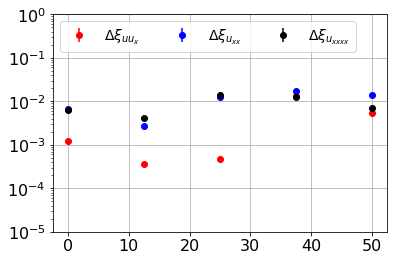

In [15]:
delta_c1_mean = np.nanmean(delta_c1, axis=0)
delta_c2_mean = np.nanmean(delta_c2, axis=0)
delta_c3_mean = np.nanmean(delta_c3, axis=0)

delta_c1_std = np.nanstd(delta_c1, axis=0)
delta_c2_std = np.nanstd(delta_c2, axis=0)
delta_c3_std = np.nanstd(delta_c3, axis=0)

# Plot average and standard deviations of the coefficient errors
plt.figure()
plt.errorbar(noise_levels / rmse * 100, y=delta_c1_mean, yerr=delta_c1_std, color='r', fmt='o', label=r'$\Delta\xi_{uu_x}$')
plt.errorbar(noise_levels / rmse * 100, y=delta_c2_mean, yerr=delta_c2_std, color='b', fmt='o', label=r'$\Delta\xi_{u_{xx}}$')
plt.errorbar(noise_levels / rmse * 100, y=delta_c3_mean, yerr=delta_c3_std, color='k', fmt='o', label=r'$\Delta\xi_{u_{xxxx}}$')
plt.yscale('log')
plt.legend(fontsize=14, loc='upper left', ncol=3)  #, framealpha=1.0, bbox_to_anchor=(1.05, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_ylim(1e-5, 1)
plt.savefig('SR3_weakformPDE_KS.pdf')

# Test weak form PDE functionality on Reaction-Diffusion system
This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. We will also need to generate the data because saving a high-resolution form of the data makes a fairly large file. This is also done in the Example 10 Jupyter notebook.

### Note that Rudy PDE-FIND paper and Messenger Weak SINDy paper use 256 spatial points in each spatial direction, but Reinbold weak SINDy PRE paper uses 512 points in each direction. We will try and get away with only 64 points in each direction for speed (with normal PDE-FIND this would be a liability because the high order derivatives are very noisy), and still show robustness to ~ 10% noise levels

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


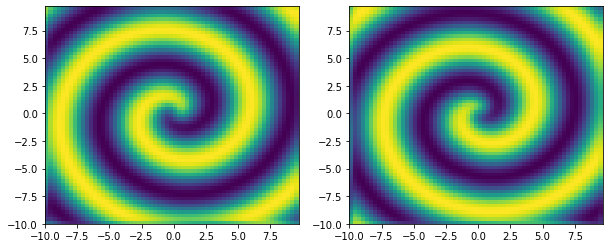

In [16]:
from scipy.integrate import solve_ivp
from numpy.fft import fft2, ifft2

# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N:2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(np.vstack((-d1 * K22 * uvt_reshaped[:N] + utrhs, 
                                        -d2 * K22 * uvt_reshaped[N:] + vtrhs)))
    return uvt_updated


# Generate the data
t = np.linspace(0, 10, int(10 / 0.05))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20  # Domain size in X and Y directions
# use n = 32 for speed but then the high-order derivatives are terrible
n = 64  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(- L / 2, L / 2, n + 1) 
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(- n2, - 1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

# define our solution vectors 
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(np.hstack((np.reshape(fft2(u[:, :, 0]), (1, N)), np.reshape(fft2(v[:, :, 0]), (1, N)))))

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, args=(K22, d1, d2, beta, n, N))
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [17]:
time = t
u = np.zeros((n, n, len(time), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol
u_flattened = np.reshape(u, (N * len(time), 2))

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [lambda x: x, lambda x: x * x * x, lambda x, y: x * y * y, lambda x, y: x * x * y]
library_function_names = [lambda x: x, lambda x: x + x + x, lambda x, y: x + y + y, lambda x, y: x + x + y]

# Need to define the 2D spatial grid before calling the library
X, Y = np.meshgrid(x, y)
spatial_grid = np.asarray([X, Y]).T
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=spatial_grid,
                        temporal_grid=time, include_bias=False, K=100,
                        is_uniform=True, weak_form=True, num_pts_per_domain=30)
u_dot_integral = convert_u_dot_2D(u, time, pde_lib)

In [18]:
# Fit the 2D reaction-diffusion equation, weak form style!
optimizer = ps.STLSQ(threshold=0.02, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

(x0)' = 1.000 x0 + -1.000 x0x0x0 + 1.000 x1x1x1 + -1.000 x0x1x1 + 1.000 x0x0x1 + 0.100 x0_11 + 0.100 x0_22
(x1)' = 0.999 x1 + -1.000 x0x0x0 + -0.999 x1x1x1 + -1.000 x0x1x1 + -0.999 x0x0x1 + 0.100 x1_11 + 0.100 x1_22


In [19]:
# Initialize noisy data
rmse = mean_squared_error(u_flattened, np.zeros(u_flattened.shape), squared=False)
u_noisy = u + np.random.normal(0, rmse / 20.0, u.shape)  # Add 5% noise
u_flattened_noisy = np.reshape(u_noisy, (N * len(time), 2))
u_dot_integral_noisy = convert_u_dot_2D(u_noisy, time, pde_lib)

# Fit the 2D reaction-diffusion equation with noise, weak form style!
optimizer = ps.STLSQ(threshold=0.02, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened_noisy, x_dot=u_dot_integral_noisy)
model.print()

(x0)' = 0.326 x0 + 0.576 x1 + -0.284 x0x0x0 + 0.368 x1x1x1 + -0.271 x0x1x1 + 0.357 x0x0x1 + 0.078 x0_11 + 0.059 x0_22 + -2.182 x0x0_1 + 2.002 x1x0_1 + 2.930 x0x0x0x0_1 + 0.896 x0x0x0x1_1 + 0.341 x1x1x1x0_1 + -1.492 x1x1x1x1_1 + -0.402 x0x1x1x0_1 + 2.198 x0x1x1x1_1 + 0.590 x0x0x1x0_1 + 1.113 x0x0x1x1_1 + -0.747 x0x0_2 + 0.735 x0x1_2 + 2.198 x1x0_2 + -0.784 x1x1_2 + -2.807 x0x0x0x1_2 + 0.813 x1x1x1x1_2 + 0.050 x0x1x1x0_2 + -1.634 x0x1x1x1_2 + -2.066 x0x0x1x0_2 + 0.535 x0x0x1x1_2 + 0.070 x0x0_11 + -1.248 x0x1_11 + -0.094 x1x0_11 + 1.327 x1x1_11 + 1.446 x0x0x0x1_11 + -0.393 x1x1x1x0_11 + 0.395 x1x1x1x1_11 + 0.392 x0x1x1x0_11 + -0.410 x0x1x1x1_11 + 0.417 x0x0x1x0_11 + -0.481 x0x0x1x1_11 + 1.592 x0x0_12 + -1.743 x1x0_12 + -2.110 x0x0x0x0_12 + -0.533 x1x1x1x0_12 + -1.322 x1x1x1x1_12 + 0.780 x0x1x1x0_12 + 1.414 x0x1x1x1_12 + 0.575 x0x0x1x0_12 + 2.004 x0x0x1x1_12 + -0.053 x0x0_22 + 0.718 x0x1_22 + 0.090 x1x0_22 + -0.758 x1x1_22 + -0.829 x0x0x0x1_22
(x1)' = -0.188 x0 + 0.216 x1 + -0.789 x0x0x0 +

# Test weak form PDE functionality on 3D Reaction-Diffusion system
We will use a 3D reaction-diffusion equation called the Gray-Scott Equation. We are folllowing the example in Section 3.3.3 of Maddu, S., Cheeseman, B. L., Sbalzarini, I. F., & Müller, C. L. (2019). Stability selection enables robust learning of partial differential equations from limited noisy data. arXiv preprint arXiv:1907.07810., https://arxiv.org/pdf/1907.07810.pdf.
$$u_t = D_u\nabla^2 u - uv^2 + 0.014(1-u)$$
$$v_t = D_v\nabla^2 v + uv^2 - 0.067 v$$
We will need to generate some very low-resolution data, because the memory requirements are very significant for a fully 3D problem. We showed in the PDE-FIND Jupyter notebook (Example 10) that the resolution is too low to get all the terms correct. 

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


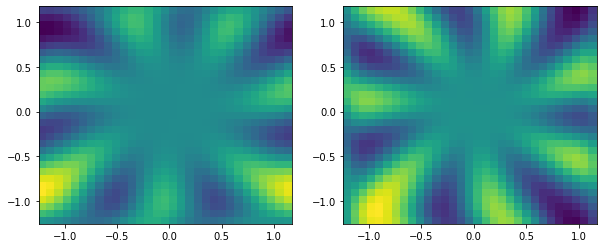

In [20]:
from numpy.fft import fftn, ifftn

# Define the reaction-diffusion PDE in the Fourier (kx, ky, kz) space
def reaction_diffusion(t, uvt, K22, d1, d2, n, N):
    ut = np.reshape(uvt[:N], (n, n, n))
    vt = np.reshape(uvt[N:2 * N], (n, n, n))
    u = np.real(ifftn(ut, axes=[0, 1, 2]))
    v = np.real(ifftn(vt, axes=[0, 1, 2]))
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fftn(0.014 * (1 - u) - uv2, axes=[0, 1, 2])), (N, 1))
    vtrhs = np.reshape((fftn(uv2 - 0.067 * v, axes=[0, 1, 2])), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(np.vstack((-d1 * K22 * uvt_reshaped[:N] + utrhs, 
                                        -d2 * K22 * uvt_reshaped[N:] + vtrhs)))
    return uvt_updated


# Generate the data
dt = 0.05
t = np.linspace(0, 10, int(5 / dt))
d1 = 2e-2
d2 = 1e-2
L = 2.5  # Domain size in X, Y, Z directions
# use n = 32 for speed but then the high-order derivatives are terrible
n = 32  # Number of spatial points in each direction
N = n * n * n
x_uniform = np.linspace(- L / 2, L / 2, n + 1) 
x = x_uniform[:n]
y = x_uniform[:n]
z = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky, kz)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(- n2, - 1, n2)))
ky = kx
kz = kx
# Get 3D meshes in (x, y, z) and (kx, ky, kz)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
K2 = KX ** 2 + KY ** 2 + KZ ** 2
K22 = np.reshape(K2, (N, 1))

m = 7  # number of spirals

# define our solution vectors 
u = np.zeros((len(x), len(y), len(z), len(t)))
v = np.zeros((len(x), len(y), len(z), len(t)))

# Initial conditions
u[:, :, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))
v[:, :, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(np.hstack((np.reshape(fftn(u[:, :, :, 0], axes=[0, 1, 2]), (1, N)), 
                             np.reshape(fftn(v[:, :, :, 0], axes=[0, 1, 2]), (1, N)))))

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, args=(K22, d1, d2, n, N))
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, z, t) space from (kx, ky, kz, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n, n))
    vt = np.reshape(uvsol[N:, j], (n, n, n))
    u[:, :, :, j] = np.real(ifftn(ut, axes=[0, 1, 2]))
    v[:, :, :, j] = np.real(ifftn(vt, axes=[0, 1, 2]))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X[:, :, 0], Y[:, :, 0], u[:, :, 0, 10])
plt.subplot(1, 2, 2)
plt.pcolor(X[:, :, 0], Y[:, :, 0], v[:, :, 0, 10])

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

u_sol = u
v_sol = v

In [21]:
time = t
u = np.zeros((n, n, n, len(time), 2))
u[:, :, :, :, 0] = u_sol
u[:, :, :, :, 1] = v_sol
u_flattened = np.reshape(u, (N * len(time), 2))

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [lambda x: x, lambda x: x * x * x, lambda x, y: x * y * y, lambda x, y: x * x * y]
library_function_names = [lambda x: x, lambda x: x + x + x, lambda x, y: x + y + y, lambda x, y: x + x + y]

# Need to define the 2D spatial grid before calling the library
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
spatial_grid = np.asarray([X, Y, Z])
spatial_grid = np.transpose(spatial_grid, axes=[1, 2, 3, 0])
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=spatial_grid,
                        temporal_grid=time, include_bias=False, K=200,
                        is_uniform=True, weak_form=True, num_pts_per_domain=20)
u_dot_integral = convert_u_dot_3D(u, time, pde_lib)

In [ ]:
# Fit the 3D reaction-diffusion equation, weak form style!
optimizer = ps.SR3(threshold=1e-2, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()